# A notebook for analyzing the networks from individual runs

In [105]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp

from scipy import stats

In [17]:
# I stole this from http://neuroplausible.com/gini

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))


In [163]:
# the EI index as described in 
# Krackhardt, D., & Stern, R. N. (1988). 
# Informal networks and organizational crises: An experimental simulation.
# Social psychology quarterly, 123-140.

def calculate_EI_index(a_graph, first_subgraph, second_subgraph):
    """
    
    = (EL - IL) / (EL + IL)
    
     The possible scores for this index range
     from -1.0 to +1.0. As the E-I index
     approaches +1.0, all the links would be
     external to the subunits. A score of -1.0
     would indicate that all the links are internal.
     If the links are divided equally, the index will
     equal zero
    
    """
    IL = len(first_subgraph.edges) + len(second_subgraph)
    
    # all of the links, minus the internal links I think.
    EL = len(a_graph.edges) - IL
    
    return (EL - IL) / (EL + IL)
    

### This is for turning my gross text thing I exported in netlogo into an actual graph so that I can do something useful 

In [135]:
def construct_graph_from_file(file_name):
    """
    Make a networkx object
    """

    g = nx.Graph()

    try:
        with open(file_name, "r") as f:
            lines = f.readlines()

            node_names = []
            node_colors = []
            node_is_adversarial = []

            edges = 0

            for line in lines:
                if line == "\n":
                    continue

                node_info = eval(line)[0]

                node_names.append(node_info[0])
                node_colors.append(node_info[1])
                node_is_adversarial.append(node_info[2])

                edges += len(node_info[-1])

                g.add_node(node_info[0], color = node_info[1], is_adversarial=node_info[2] )

                for other_node in node_info[-1]:
                    # should check if the edge exists first
                    g.add_edge(node_info[0], other_node, color="blue")
                    
    except FileNotFoundError:
        print("Did not find {}".format(file_name))
                
    return g


In [140]:
def construct_subgraphs(a_graph, expected_matching_prop, run_number, field = "is_adversarial", sanity_check=True):
    """
    
    Args:
    - a_graph: (networkx graph object)
    - expected_matching_prop: float
    - field
    
    Returns coop, adver
    or 
    matching, not matching
    
    """
    
    bad_or_nah = np.array(list(g.nodes.data("is_adversarial")))

    cooperator_nodes = bad_or_nah[np.where(bad_or_nah[:, 1] == 0)][:, 0]
    adversary_nodes = bad_or_nah[np.where(bad_or_nah[:, 1] != 0)][:, 0]

    adversary_graph = g.subgraph(adversary_nodes)
    cooperator_graph = g.subgraph(cooperator_nodes)
    
    # make sure these are the correct graphs
    if sanity_check:
        g_colors = np.array(list(cooperator_graph.nodes.data("color")))

        num_same_color = stats.mode(g_colors[:,1])[1][0]
        
        err_string = "Run number: {}, Got: {}, Expected: {}".format(run_number, num_same_color/100, expected_matching_prop)
        
        # this is gonna be a little off because it actually writes at 501, and I don't have that data
        # I hate myself
        # I think it's ok, but this should still catch the cases where it isn't right at all
        if not abs(num_same_color/100 - expected_matching_prop) < 0.05:
            print(err_string)
    
    if field == "is_adversarial":
        return cooperator_graph, cooperator_nodes, adversary_graph, adversary_nodes
    
    elif field == "color":
        # this should probably be only the cooperator nodes

        g_colors = np.array(list(cooperator_graph.nodes.data("color")))
        
        most_popular_color = stats.mode(g_colors[:,1])[0]
        
        matching_nodes = g_colors[np.where(g_colors[:, 1] == most_popular_color)][:, 0]
        other_nodes = g_colors[np.where(g_colors[:, 1] != most_popular_color)][:, 0]

        subgraph1 = g.subgraph(matching_nodes)
        subgraph2 = g.subgraph(other_nodes)
    
    return subgraph1, matching_nodes, subgraph2, other_nodes
    

In [156]:
def select_subset_of_dict(a_dict, keys):
    
    a_list = []
    
    for k in list(keys):
        a_list.append(a_dict[k])
    
    return np.array(a_list)

## Begin actual batches for analysis

In [106]:
df = pd.read_csv("./BehaviorSpace_output/cleaned_" + "random_blend" + "-spreadsheet.csv")


C:\Users\Matt\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,25

In [126]:
df.iloc[:, :10]

,[run number],1,1.1,2,2.1,3,3.1,4,4.1,5
0,is-network-fixed,false,NaN,false,NaN,false,NaN,false,NaN,false
1,enforce-max-links,false,NaN,false,NaN,false,NaN,false,NaN,false
2,number-of-adversarial,10,NaN,10,NaN,10,NaN,10,NaN,10
3,number-of-nodes,100,NaN,100,NaN,100,NaN,100,NaN,100
4,memory-duration,100,NaN,100,NaN,100,NaN,100,NaN,100
5,color-mismatch-tolerance,0.25,NaN,0.25,NaN,0.25,NaN,0.25,NaN,0.25
6,connection-strategy,"""reputation""",NaN,"""reputation""",NaN,"""reputation""",NaN,"""reputation""",NaN,"""reputation"""
7,number-of-colors,10,NaN,10,NaN,10,NaN,10,NaN,10
8,initial-network-structure,"""from-file""",NaN,"""from-file""",NaN,"""from-file""",NaN,"""from-file""",NaN,"""from-file"""
9,cooperator-color-change-strategy,"""naive-majority-vote""",NaN,"""naive-majority-vote""",NaN,"""naive-majority-vote""",NaN,"""naive-majority-vote""",NaN,"""naive-majority-vote"""


###  I'm about to repeat the same thing like 6 times, but I think it is going to be easier than doing it once and slicing and all of that nonsesne

In [167]:
# all of the data together.

# all of the numpy arrays to keep track of the things I care about go here...
# holy shit this is dumb, I should use a data frame or a dict or anything else
avg_clustering = np.array([])

avg_degree_centrality = np.array([])
gini_degree_centrality = np.array([])

avg_degree_centrality = np.array([])
gini_degree_centrality = np.array([])

avg_betweenness_centrality = np.array([])
gini_betweenness_centrality = np.array([])

EI_index_array = np.array([])

coop_avg_degree_centrality = np.array([])
coop_gini_degree_centrality = np.array([])

coop_avg_degree_centrality = np.array([])
coop_gini_degree_centrality = np.array([])

coop_avg_betweenness_centrality = np.array([])
coop_gini_betweenness_centrality = np.array([])

adver_avg_degree_centrality = np.array([])
adver_gini_degree_centrality = np.array([])

adver_avg_degree_centrality = np.array([])
adver_gini_degree_centrality = np.array([])

adver_avg_betweenness_centrality = np.array([])
adver_gini_betweenness_centrality = np.array([])

for exp_name in ["new_rep_dis", "rep_blendHighHigh", "rep_blendLowHigh", "fixed_dis",
                 "fixed_blend", "random_blend", "random_dis"]:  # obvi missing some of the data.

    df = pd.read_csv("./BehaviorSpace_output/cleaned_" + exp_name + "-spreadsheet.csv")
    
    
    run_number = 1
    print(exp_name)
    
    for ii in range(1, df.shape[1], 2): # the cols with the data in them
        if ii % 100 == 0:
            print(ii)
        
        network = df.iloc[11, ii].strip('"')  # need this all the time to find the file
        final_matching_prop = float(df.iloc[20, ii])
        best_possible_matching_prop = float(df.iloc[20, ii+1])

        
        g = construct_graph_from_file("./networks/"+network+"/" + exp_name +"_" + str(run_number) +"_final.txt")
        
        # whole graph stuff here
        avg_clustering = np.append(avg_clustering, nx.algorithms.cluster.average_clustering(g))
        
        degree = nx.algorithms.centrality.degree_centrality(g)
        avg_degree_centrality = np.append(avg_degree_centrality, np.mean(list(degree.values())))
        gini_degree_centrality = np.append(gini_degree_centrality, gini(np.array(list(degree.values()))))
        
        between = nx.algorithms.centrality.betweenness_centrality(g)
        avg_betweenness_centrality = np.append(avg_betweenness_centrality, np.mean(list(between.values())))
        gini_betweenness_centrality = np.append(gini_betweenness_centrality, gini(np.array(list(between.values()))))

        
        coop_graph, coop_nodes, adver_graph, adver_nodes = construct_subgraphs(g, final_matching_prop, run_number)
        
        # subgraph stuff here
        coop_degree = select_subset_of_dict(degree, coop_nodes)
        coop_avg_degree_centrality = np.append(coop_avg_degree_centrality, np.mean(coop_degree))
        coop_gini_degree_centrality = np.append(coop_gini_degree_centrality, gini(coop_degree))
        
        coop_btw = select_subset_of_dict(between, coop_nodes)
        coop_avg_betweenness_centrality = np.append(coop_avg_betweenness_centrality, np.mean(coop_btw))
        coop_gini_betweenness_centrality = np.append(coop_gini_betweenness_centrality, gini(coop_btw))
        
        adver_degree = select_subset_of_dict(degree, adver_nodes)
        adver_avg_degree_centrality = np.append(adver_avg_degree_centrality, np.mean(adver_degree))
        adver_gini_degree_centrality = np.append(adver_gini_degree_centrality, gini(adver_degree))
        
        adver_btw = select_subset_of_dict(between, adver_nodes)
        adver_avg_betweenness_centrality = np.append(adver_avg_betweenness_centrality, np.mean(adver_btw))
        adver_gini_betweenness_centrality = np.append(adver_gini_betweenness_centrality, gini(adver_btw))
        
        EI_index_array = np.append(EI_index_array, calculate_EI_index(g, coop_graph, adver_graph))
        
        run_number += 1
            
        
        


fixed_blend
Did not find ./networks/Barabasi1/fixed_blend_1_final.txt


ZeroDivisionError: division by zero

In [ ]:
# Network type RQ:

# need some validation that these are actually the correct files from each run

all_

for exp_name in ["new_rep_dis", "rep_blendHighHigh", "rep_blendLowHigh", "fixed_dis",
                 "fixed_blend", "random_blend", "random_dis"]:  # obvi missing some of the data.

    df = pd.read_csv("./BehaviorSpace_output/cleaned_" + exp_name + "-spreadsheet.csv")
    
    print(exp_name, df.iloc[24].describe())
    

    for ii in range(1, df.shape[1], 2): # the cols with the data in them
        network = df.iloc[11, ii].strip('"')

        if network == "Barabasi1":
            b_durations = np.append(b_durations, int(df.iloc[24, ii]))
        elif network == "Erdos_Renyi1":
            e_durations = np.append(e_durations, int(df.iloc[24, ii]))
        elif network == "Lattice1":
            l_durations = np.append(l_durations, int(df.iloc[24, ii]))
        elif network == "Watts_Strogatz1":
            w_durations = np.append(w_durations, int(df.iloc[24, ii]))
            


In [ ]:
# Iterate over all of the

matched_percentage = np.array([])

for exp_name in ["new_rep_dis", "rep_blendHighHigh", "rep_blendLowHigh", "fixed_dis",
                 "fixed_blend", "random_blend", "random_dis"]:  # obvi missing some of the data.
        
    df = pd.read_csv("./BehaviorSpace_output/cleaned_" + exp_name + "-spreadsheet.csv")
    
    for ii in range(1, df.shape[1], 2):
        this_runs_steps = int(df.iloc[24, ii])
        
        if this_runs_steps >= 500:  # you did not converge (unless you did at the end?)
            matched_percentage = np.append(matched_percentage, float(df.iloc[526, ii]) / float(df.iloc[526, ii+1]))

In [141]:
g = construct_graph_from_file("./networks/Barabasi1/rep_dis_12017_final.txt")

In [142]:
coop_graph, coop_nodes, adver_graph, adver_nodes = construct_subgraphs(g, final_matching_prop, run_number)


Run number: 1, Got: 0.11, Expected: 0.19


In [102]:
most_popular_color_graph, other_colors_graph = construct_subgraphs(g, field="color") 

C:\Users\Matt\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


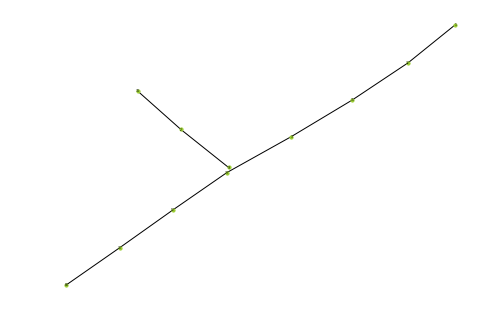

In [104]:
pos = nx.drawing.layout.kamada_kawai_layout(most_popular_color_graph)

nx.draw(most_popular_color_graph, pos=pos, with_labels=True, font_size=3,
        node_color='yellowgreen', node_size=10)

plt.show()

In [89]:
adver_graph, coop_graph = construct_subgraphs(g, field="is_adversarial")

C:\Users\Matt\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


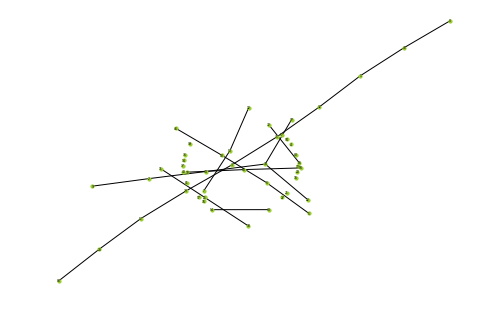

In [70]:
pos = nx.drawing.layout.kamada_kawai_layout(cooperator_graph)

nx.draw(cooperator_graph, pos=pos, with_labels=True, font_size=3,
        node_color='yellowgreen', node_size=10)

plt.show()

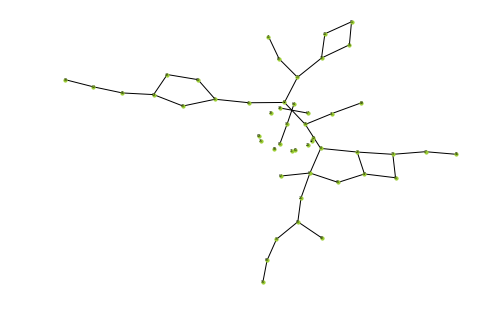

In [71]:
pos = nx.drawing.layout.kamada_kawai_layout(adversary_graph)

nx.draw(adversary_graph, pos=pos, with_labels=True, font_size=3,
        node_color='yellowgreen', node_size=10)

plt.show()

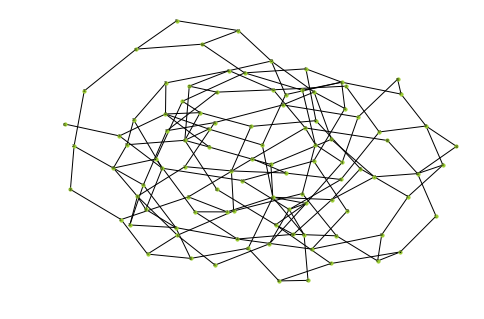

In [72]:
pos = nx.drawing.layout.kamada_kawai_layout(g)

nx.draw(g, pos=pos, with_labels=True, font_size=3,
        node_color='yellowgreen', node_size=10)

plt.show()

In [74]:
EI_index(g, cooperator_graph, adversary_graph)

0.07975460122699386

In [149]:
len(adver_nodes)

50

In [151]:

x = nx.algorithms.centrality.betweenness_centrality(g)

In [152]:
x[77]

0.002977622025241072

In [145]:
nx.algorithms.centrality.betweenness_centrality(g[list(adver_nodes)])

TypeError: unhashable type: 'list'

(array([12., 22., 36., 14., 12.,  3.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.01282865, 0.0256573 , 0.03848595, 0.05131459,
        0.06414324, 0.07697189, 0.08980054, 0.10262919, 0.11545784,
        0.12828648]),
 <a list of 10 Patch objects>)

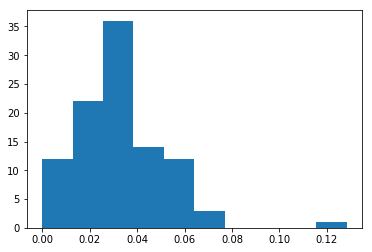

In [56]:
plt.hist(nx.algorithms.centrality.betweenness_centrality(g).values())

(array([ 1., 12.,  0., 60.,  0., 17.,  8.,  0.,  1.,  1.]),
 array([0.01010101, 0.01616162, 0.02222222, 0.02828283, 0.03434343,
        0.04040404, 0.04646465, 0.05252525, 0.05858586, 0.06464646,
        0.07070707]),
 <a list of 10 Patch objects>)

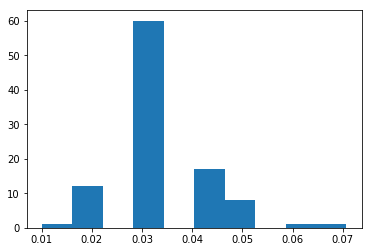

In [57]:
plt.hist(nx.algorithms.centrality.degree_centrality(g).values())

In [58]:
gini(np.array(list(nx.algorithms.centrality.degree_centrality(g).values())))

0.13484621626455803

In [155]:
nx.algorithms.cluster.average_clustering(g)

0.011333333333333332

In [160]:
np.mean(list(nx.algorithms.centrality.degree_centrality(g).values()))

0.032929292929292926